In [46]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata as ad 

from scipy.stats import spearmanr

import xgboost as xgb 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn import svm

from tqdm import tqdm 
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path

from config import FDIR_EXTERNAL, FDIR_RAW, FDIR_PROCESSED, FDIR_INTEMEDIATE

In [47]:
fdir_raw = FDIR_RAW
fdir_intermediate = FDIR_INTEMEDIATE
fdir_processed = FDIR_PROCESSED / 'sex'
fdir_external = FDIR_EXTERNAL

ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'
# model_type = 'knn'

feature_importance_method = 'native'
feature_importance_method = 'SHAP'

n_features = 0

value_to_predict = 'Age'

organ = "HEART"
organ = "BRAIN0"
# organ = "BRAIN1"
# organ = 'CAGE.HEART'

# 
sex = 'male'
sex = 'female'

# n_opt_features = {
#     "HEART": {
#         "male": 9,
#         "female": 11
#     }, 
#     "BRAIN0": {
#         "male": 7,
#         "female": 7
#     }, 
#     "BRAIN1": {
#         "male": 17,
#         "female": 8
#     }, 
# }


In [48]:
# adata = ad.read_h5ad(fdir_intermediate/f'{organ.upper()}.raw.h5ad')
adata = ad.read_h5ad(fdir_processed / f'{organ.upper()}.preprocessed.sex.h5ad')

adata.obs['age'] = adata.obs['Age']

adata = adata[adata.obs['age'].notna()]

adata.var_names = "tr_" + adata.var_names

adata_male = adata[adata.obs['sex'] == "male"]
adata_female = adata[adata.obs['sex'] == "female"]
# adata_both = adata.copy()
adata_female


View of AnnData object with n_obs × n_vars = 9 × 380224
    obs: 'Age', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'Center Name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'GEO_Accession (exp)', 'Instrument', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'RACE', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'sex', 'source_name', 'SRA Study', 'tissuebank', 'pmi', 'age'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'
    varm: 'autosomes', 'chr_aX', 'chr_aXY', 'chr_aY'
    layers: 'raw'

In [49]:
# rhos_male = []
# pvalues_male = []
# rhos_female = []
# pvalues_female = []

# rhos = []
# pvalues = []

# for i in tqdm(range(adata_male.n_vars)):
#     # rho, pvalue = spearmanr(X[:, i], y)
#     rho, pvalue = spearmanr(adata_male.X[:, i], adata_male.obs['age'].values)
#     rhos_male.append(rho)
#     pvalues_male.append(pvalue)
    
# # for i in tqdm(range(adata_female.n_vars)):
#     rho, pvalue = spearmanr(adata_female.X[:, i], adata_female.obs['age'].values)
#     rhos_female.append(rho)
#     pvalues_female.append(pvalue)
# # rho, pvalue = spearmanr(X, y.values.reshape(1,-1), axis=1)
# rhos_male = np.array(rhos_male)
# rhos_female = np.array(rhos_female)

# rhos_male_nonan_ids = np.argwhere(~np.isnan(rhos_male)).ravel()
# rhos_female_nonan_ids = np.argwhere(~np.isnan(rhos_female)).ravel()


# for i in tqdm(range(adata.n_vars)):
#     # rho, pvalue = spearmanr(X[:, i], y)
#     rho, pvalue = spearmanr(adata.X[:, i], adata.obs['age'].values)
#     rhos.append(rho)
#     pvalues.append(pvalue)
    
# rhos = np.array(rhos)
# rhos_nonan_ids  = np.argwhere(~np.isnan(rhos)).ravel()

In [50]:
from scipy.stats import rankdata
from scipy.stats import t

def spearman_vectorized(X, y):
    """Compute Spearman correlation between columns of X and vector y."""
    X_ranked = np.apply_along_axis(rankdata, 0, X)
    y_ranked = rankdata(y)
    
    # Normalize
    X_ranked -= X_ranked.mean(axis=0)
    y_ranked -= y_ranked.mean()
    
    X_ranked /= X_ranked.std(axis=0)
    y_ranked /= y_ranked.std()
    
    # Compute correlation
    rhos = np.dot(X_ranked.T, y_ranked) / X_ranked.shape[0]
    return rhos

def spearman_pvalues(rho, n):
    t_stat = rho * np.sqrt((n - 2) / (1 - rho ** 2))
    pvals = 2 * t.sf(np.abs(t_stat), df=n - 2)
    return pvals

# Male
rhos_male = spearman_vectorized(adata_male.X, adata_male.obs['age'].values)
rhos_male = np.array(rhos_male)
rhos_male_nonan_ids = np.where(~np.isnan(rhos_male))[0]

# Female
rhos_female = spearman_vectorized(adata_female.X, adata_female.obs['age'].values)
rhos_female = np.array(rhos_female)
rhos_female_nonan_ids = np.where(~np.isnan(rhos_female))[0]

# Combined dataset
rhos = spearman_vectorized(adata.X, adata.obs['age'].values)
rhos = np.array(rhos)
rhos_nonan_ids = np.where(~np.isnan(rhos))[0]

n_male = adata_male.shape[0]
pvalues_male = spearman_pvalues(rhos_male, n_male)

n_female = adata_female.shape[0]
pvalues_female = spearman_pvalues(rhos_female, n_female)

n_total = adata.shape[0]
pvalues = spearman_pvalues(rhos, n_total)

/tmp/ipykernel_214078/4075632525.py:13: RuntimeWarning: invalid value encountered in divide
  X_ranked /= X_ranked.std(axis=0)


In [51]:
adata_male.varm['rho'] = rhos_male
adata_female.varm['rho'] = rhos_female
adata.varm['rho'] = np.array(rhos)

adata_male.varm['pvalue'] = np.array(pvalues_male)
adata_female.varm['pvalue'] = np.array(pvalues_female)
adata.varm['pvalue'] = np.array(pvalues)

adata_male_nona = adata_male[:, rhos_male_nonan_ids].copy()
adata_female_nona = adata_female[:, rhos_female_nonan_ids].copy()
adata_nona = adata[:, rhos_nonan_ids].copy()

adata_eval = adata.copy()

/tmp/ipykernel_214078/1010159846.py:1: ImplicitModificationWarning: Setting element `.varm['rho']` of view, initializing view as actual.
  adata_male.varm['rho'] = rhos_male
/tmp/ipykernel_214078/1010159846.py:2: ImplicitModificationWarning: Setting element `.varm['rho']` of view, initializing view as actual.
  adata_female.varm['rho'] = rhos_female


In [52]:
#! BY R VALUE

datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

transcripts_dict = {
    "Both": [],
    "Male": [],
    "Female": []        
}


for key, dataset in datasets.items(): 

    unsignificant_corr_ids = np.argwhere(dataset.varm['pvalue'] > 0.05)

    rhos_ = np.array(dataset.varm['rho'])
    rhos_[unsignificant_corr_ids] = 0
    rhos_[np.argwhere(dataset.X.mean(axis=0) == 0)] = 0


    corr_threshold = 0.96
    corr_threshold = 0.5
    corr_threshold = 0.3

    if np.abs(rhos_).max() > corr_threshold:
        
        sorted_corr_border = np.argwhere(np.sort(np.abs(rhos_))[::-1] > corr_threshold).max()
        sorted_corr_ids = np.argsort(np.abs(rhos_))[::-1][:sorted_corr_border]
    else:
        sorted_corr_ids = []

    transcripts_dict[key] = dataset.var.index[sorted_corr_ids]
transcripts_dict

{'Both': Index(['tr_MSTRG.25959.1', 'tr_ENST00000543486.1', 'tr_ENST00000585958.5',
        'tr_ENST00000685547.2', 'tr_ENST00000381461.6', 'tr_ENST00000561602.1',
        'tr_ENST00000524230.9', 'tr_ENST00000503363.1', 'tr_ENST00000606797.5',
        'tr_ENST00000355105.8',
        ...
        'tr_ENST00000626933.1', 'tr_ENST00000561898.1', 'tr_ENST00000548263.5',
        'tr_MSTRG.31465.10', 'tr_ENST00000609327.2', 'tr_ENST00000522538.5',
        'tr_ENST00000656192.1', 'tr_ENST00000392842.6', 'tr_ENST00000673511.1',
        'tr_ENST00000506790.1'],
       dtype='object', length=15480),
 'Male': Index(['tr_ENST00000602358.5', 'tr_MSTRG.23205.7', 'tr_ENST00000586956.5',
        'tr_ENST00000484825.1', 'tr_MSTRG.27834.4', 'tr_ENST00000553334.1',
        'tr_ENST00000508696.1', 'tr_MSTRG.13533.68', 'tr_MSTRG.23208.58',
        'tr_ENST00000515723.1',
        ...
        'tr_MSTRG.4769.15', 'tr_ENST00000503507.1', 'tr_ENST00000688083.2',
        'tr_MSTRG.14072.159', 'tr_ENST00000505075.

In [53]:
# #! BY SEURAT VARIABLE IMPORTANCE

# flavor = 'cell_ranger'
flavor = 'seurat_v3_paper'
flavor = 'seurat_v3'
# flavor = 'seurat'

n_top_genes = 1000

sc.pp.highly_variable_genes(adata_nona, n_top_genes=n_top_genes, flavor=flavor)
# sc.pl.highly_variable_genes(adata_nona,log=True)

sc.pp.highly_variable_genes(adata_male_nona, n_top_genes=n_top_genes, flavor=flavor)
# sc.pl.highly_variable_genes(adata_male_nona,log=True)

sc.pp.highly_variable_genes(adata_female_nona, n_top_genes=n_top_genes, flavor=flavor)
# sc.pl.highly_variable_genes(adata_female_nona,log=True)


if flavor == 'seurat':
    transcripts_all = adata_nona.var['dispersions_norm'].loc[adata_nona.var['highly_variable']].sort_values()[::-1].index
    transcripts_m = adata_male_nona.var['dispersions_norm'].loc[adata_male_nona.var['highly_variable']].sort_values()[::-1].index
    transcripts_f = adata_female_nona.var['dispersions_norm'].loc[adata_female_nona.var['highly_variable']].sort_values()[::-1].index

else:
    transcripts_all = adata_nona.var['highly_variable_rank'][adata_nona.var['highly_variable']].sort_values().index
    transcripts_m = adata_male_nona.var['highly_variable_rank'][adata_male_nona.var['highly_variable']].sort_values().index
    transcripts_f = adata_female_nona.var['highly_variable_rank'][adata_female_nona.var['highly_variable']].sort_values().index

datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

transcripts_dict = {
    "Both": transcripts_all,
    "Male": transcripts_m,
    "Female": transcripts_f        
}

cv = LeaveOneOut()


for key, dataset in datasets.items(): 
    transcripts = transcripts_dict[key]
    
    ranks = np.zeros(n_top_genes)
    X = dataset[:, transcripts].X
    y = dataset.obs['age'].values
    
    for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]
        
        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test
        
        # model = xgb.XGBRegressor(n_estimators=300, max_depth=4)
        model = svm.SVR(kernel="linear")
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        # if i > 1:
        #     break
        ranks += np.abs(model.coef_).ravel().tolist()
        # ranks += model.feature_importances_
        
    transcripts_dict[key] = transcripts[ranks.argsort()[::-1][:100]]


/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/arsenii/miniconda3/envs/rnaseq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
34it [00:00, 1187.80it/s]
25it [00:00, 1375.52it/s]
9it [00:00, 1793.37it/s]


In [54]:
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler


datasets = {
    'Both': adata_nona,
    'Male': adata_male_nona,
    'Female': adata_female_nona
}

scores = {
    'r2': {},
    'RMSE': {}
} 

print(f"{min(adata_nona.shape[0], adata_male_nona.shape[0], adata_female_nona.shape[0])}")

for key, dataset in datasets.items():
    rmses = []
    r2_scores = []
    
    if min(adata_nona.shape[0], adata_male_nona.shape[0], adata_female_nona.shape[0]) < 10:
        cv  = LeaveOneOut()
    else:
        cv = StratifiedKFold(n_splits=5)
    
    transcripts = transcripts_dict[key]
    
    for n_features in (range(1, 30)):

        X = dataset[:, transcripts[:n_features]].X
        y = dataset.obs['age'].values

        # print(X.shape)
        print(f"{n_features=}")
        
        preds = []
        vals  = []
        gls_preds = []
        
        for i, (train, val) in tqdm(enumerate(cv.split(X, y))):
            X_train = X[train]
            y_train = y[train]
            X_test = X[val]
            y_test = y[val]
            
            train_scaler = RobustScaler().fit(X_train)
            X_train = train_scaler.transform(X_train)
            X_test = train_scaler.transform(X_test)
            

            X_train_ = X_train
            y_train_ = y_train
            X_val = X_test
            y_val = y_test
            
            model = svm.SVR(kernel='linear')
            # model = svm.LinearSVR(loss='squared_epsilon_insensitive')
            # model = LinearRegression()
            # model = Ridge()
            # model = xgb.XGBRegressor(n_estimators=300, max_depth=4, )
            # model = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
            #                      param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 20)})    
            model.fit(X_train_, y_train_)
            pred = model.predict(X_val)


            preds.extend(pred)
            vals.extend(y_val)

        rmses.append(RMSE(np.ravel(preds), np.ravel(vals)))
        r2_scores.append(r2_score(np.ravel(vals), np.ravel(preds)))
        
        print("RMSE: ", RMSE(np.ravel(preds), np.ravel(vals)))
        print("R2: ", r2_score(np.ravel(vals), np.ravel(preds)))
        
    scores['RMSE'][key] = rmses
    scores['r2'][key] = r2_scores

    print("-"*20)


# model.coef_

9
n_features=1


34it [00:00, 879.15it/s]


RMSE:  10.512703740446895
R2:  -0.07233156424520315
n_features=2


34it [00:00, 332.92it/s]


RMSE:  10.757851622695322
R2:  -0.12292651918359265
n_features=3


34it [00:00, 341.07it/s]


RMSE:  10.822260912037109
R2:  -0.1364131183727253
n_features=4


34it [00:00, 270.94it/s]


RMSE:  10.681894595852377
R2:  -0.10712540048159025
n_features=5


34it [00:00, 322.40it/s]


RMSE:  10.754912769835208
R2:  -0.12231307606093411
n_features=6


34it [00:01, 30.33it/s]


RMSE:  9.101851784231775
R2:  0.196178243890764
n_features=7


34it [00:00, 76.56it/s]


RMSE:  8.505160161637722
R2:  0.29811618031201537
n_features=8


34it [00:00, 86.31it/s]


RMSE:  7.745021433554685
R2:  0.4179698447272787
n_features=9


34it [00:00, 136.15it/s]


RMSE:  8.028296287696632
R2:  0.37461563099548145
n_features=10


34it [00:00, 43.02it/s]


RMSE:  6.7456467929291035
R2:  0.5584829968345841
n_features=11


34it [00:00, 83.23it/s]


RMSE:  6.9074415837833385
R2:  0.537049369533436
n_features=12


34it [00:00, 249.70it/s]


RMSE:  6.791448421829387
R2:  0.5524670132086418
n_features=13


34it [00:01, 26.97it/s]


RMSE:  6.071497484870119
R2:  0.6423222892785418
n_features=14


34it [00:01, 30.40it/s]


RMSE:  6.1210133351012095
R2:  0.6364644476141448
n_features=15


34it [00:00, 38.34it/s]


RMSE:  7.222135987592075
R2:  0.49390556533403485
n_features=16


34it [00:00, 36.06it/s]


RMSE:  7.320753247778337
R2:  0.4799899034684004
n_features=17


34it [00:01, 26.27it/s]


RMSE:  6.549795520259213
R2:  0.5837485857903973
n_features=18


34it [00:01, 26.85it/s]


RMSE:  6.110075473520214
R2:  0.6377625166217648
n_features=19


34it [00:01, 31.28it/s]


RMSE:  5.698972978245948
R2:  0.6848673265415915
n_features=20


34it [00:01, 27.87it/s]


RMSE:  5.214866804533023
R2:  0.7361320281004897
n_features=21


34it [00:02, 12.01it/s]


RMSE:  4.841246772493784
R2:  0.7725873184414823
n_features=22


34it [00:02, 13.73it/s]


RMSE:  5.024500225482997
R2:  0.7550451862652697
n_features=23


34it [00:02, 13.32it/s]


RMSE:  5.308306830083408
R2:  0.7265913350590016
n_features=24


34it [00:01, 22.62it/s]


RMSE:  5.58844696043269
R2:  0.6969721774334212
n_features=25


34it [00:02, 14.23it/s]


RMSE:  4.676998913503339
R2:  0.7877563154652543
n_features=26


34it [00:01, 29.46it/s]


RMSE:  4.924423517801012
R2:  0.7647059030387067
n_features=27


34it [00:01, 29.98it/s]


RMSE:  4.933185112578758
R2:  0.7638678819007569
n_features=28


34it [00:01, 27.93it/s]


RMSE:  4.752994540620491
R2:  0.7808028671205101
n_features=29


34it [00:00, 57.86it/s]


RMSE:  4.609565686716069
R2:  0.7938324763463689
--------------------
n_features=1


25it [00:00, 884.67it/s]


RMSE:  6.945957237911265
R2:  0.004031205598248544
n_features=2


25it [00:00, 790.23it/s]


RMSE:  6.90777726857249
R2:  0.014950233018587333
n_features=3


25it [00:00, 748.60it/s]


RMSE:  7.570913854604096
R2:  -0.18325440517729064
n_features=4


25it [00:00, 672.75it/s]


RMSE:  6.146476606346036
R2:  0.22010885948525472
n_features=5


25it [00:00, 671.02it/s]


RMSE:  6.31549271006829
R2:  0.17662818381461998
n_features=6


25it [00:00, 672.90it/s]


RMSE:  6.264588779004061
R2:  0.18984772241165493
n_features=7


25it [00:00, 646.49it/s]


RMSE:  5.8752676847419325
R2:  0.2874147351166596
n_features=8


25it [00:00, 538.44it/s]


RMSE:  5.8452238296451045
R2:  0.2946838746314949
n_features=9


25it [00:00, 580.01it/s]


RMSE:  3.985040245439988
R2:  0.6721713205638047
n_features=10


25it [00:00, 553.86it/s]


RMSE:  3.6281616519094215
R2:  0.7282592446908008
n_features=11


25it [00:00, 548.62it/s]


RMSE:  3.7177193356098983
R2:  0.7146783537627226
n_features=12


25it [00:00, 528.59it/s]


RMSE:  3.8046543624483475
R2:  0.7011784330472726
n_features=13


25it [00:00, 496.26it/s]


RMSE:  4.006794494210314
R2:  0.6685823317389581
n_features=14


25it [00:00, 450.65it/s]


RMSE:  3.769394743475804
R2:  0.7066914236494455
n_features=15


25it [00:00, 441.09it/s]


RMSE:  3.2101878287606795
R2:  0.7872633047644337
n_features=16


25it [00:00, 446.43it/s]


RMSE:  3.0996148818052274
R2:  0.8016660800735642
n_features=17


25it [00:00, 432.43it/s]


RMSE:  3.0969042929684965
R2:  0.8020128113066723
n_features=18


25it [00:00, 432.33it/s]


RMSE:  3.3127083670339266
R2:  0.7734584174549027
n_features=19


25it [00:00, 406.92it/s]


RMSE:  3.2992837631101297
R2:  0.7752907965566345
n_features=20


25it [00:00, 384.40it/s]


RMSE:  3.542139425356892
R2:  0.7409922110609961
n_features=21


25it [00:00, 363.96it/s]


RMSE:  2.7136156030971934
R2:  0.8479878938480037
n_features=22


25it [00:00, 371.85it/s]


RMSE:  2.855683285646589
R2:  0.8316544658326459
n_features=23


25it [00:00, 344.42it/s]


RMSE:  3.088650962284199
R2:  0.803066687169311
n_features=24


25it [00:00, 350.41it/s]


RMSE:  2.5283552831879965
R2:  0.8680353159675847
n_features=25


25it [00:00, 336.28it/s]


RMSE:  2.3196761055819874
R2:  0.8889199110927795
n_features=26


25it [00:00, 300.33it/s]


RMSE:  2.0973862590768757
R2:  0.9091890210115997
n_features=27


25it [00:00, 300.47it/s]


RMSE:  2.2748872803882687
R2:  0.8931680180160785
n_features=28


25it [00:00, 295.07it/s]


RMSE:  2.3716281310823577
R2:  0.8838886413301543
n_features=29


25it [00:00, 285.90it/s]


RMSE:  2.415688334955788
R2:  0.8795343231511455
--------------------
n_features=1


9it [00:00, 879.74it/s]


RMSE:  9.888928583642022
R2:  0.6119408391572532
n_features=2


9it [00:00, 805.38it/s]


RMSE:  8.258667517468115
R2:  0.7293429001425279
n_features=3


9it [00:00, 612.20it/s]


RMSE:  9.410648656526675
R2:  0.6485702058071932
n_features=4


9it [00:00, 571.21it/s]


RMSE:  9.64672677049918
R2:  0.6307169151402161
n_features=5


9it [00:00, 593.74it/s]


RMSE:  9.256749386838756
R2:  0.6599705983700807
n_features=6


9it [00:00, 582.53it/s]


RMSE:  9.095417527303312
R2:  0.671719761920729
n_features=7


9it [00:00, 612.17it/s]


RMSE:  9.383436094149841
R2:  0.650599710583357
n_features=8


9it [00:00, 571.74it/s]


RMSE:  9.564669342289601
R2:  0.63697262052645
n_features=9


9it [00:00, 552.33it/s]


RMSE:  10.02970873134069
R2:  0.6008132649383663
n_features=10


9it [00:00, 553.56it/s]


RMSE:  9.989153518114561
R2:  0.6040349682203947
n_features=11


9it [00:00, 528.64it/s]


RMSE:  10.203997379611346
R2:  0.5868191963368443
n_features=12


9it [00:00, 523.34it/s]


RMSE:  9.896941139005994
R2:  0.6113117305200426
n_features=13


9it [00:00, 493.11it/s]


RMSE:  9.417641951579062
R2:  0.6480476986978496
n_features=14


9it [00:00, 463.62it/s]


RMSE:  7.638813965958108
R2:  0.768446512672553
n_features=15


9it [00:00, 449.60it/s]


RMSE:  7.620524463298264
R2:  0.7695539956518758
n_features=16


9it [00:00, 435.71it/s]


RMSE:  7.944321460001925
R2:  0.7495545894450512
n_features=17


9it [00:00, 436.04it/s]


RMSE:  8.24651798749187
R2:  0.7301386550871947
n_features=18


9it [00:00, 432.85it/s]


RMSE:  15.10726668823175
R2:  0.0943273540104893
n_features=19


9it [00:00, 416.70it/s]


RMSE:  14.812670477092851
R2:  0.12930473546453114
n_features=20


9it [00:00, 406.70it/s]


RMSE:  14.217038898933097
R2:  0.19791986089771096
n_features=21


9it [00:00, 403.57it/s]


RMSE:  12.747496553133743
R2:  0.3551640143962038
n_features=22


9it [00:00, 390.16it/s]


RMSE:  12.149875992581386
R2:  0.4142083863686289
n_features=23


9it [00:00, 354.51it/s]


RMSE:  12.065612031229211
R2:  0.4223055806026067
n_features=24


9it [00:00, 362.55it/s]


RMSE:  11.439610380491525
R2:  0.4806956918355181
n_features=25


9it [00:00, 356.06it/s]


RMSE:  11.209664760265452
R2:  0.501362761755805
n_features=26


9it [00:00, 352.55it/s]


RMSE:  10.881790597439771
R2:  0.5301056880693309
n_features=27


9it [00:00, 351.03it/s]


RMSE:  10.719604010312022
R2:  0.544008293103581
n_features=28


9it [00:00, 344.79it/s]


RMSE:  10.781867778972966
R2:  0.5386957428442245
n_features=29


9it [00:00, 335.06it/s]


RMSE:  10.839492120615617
R2:  0.5337516292345713
--------------------


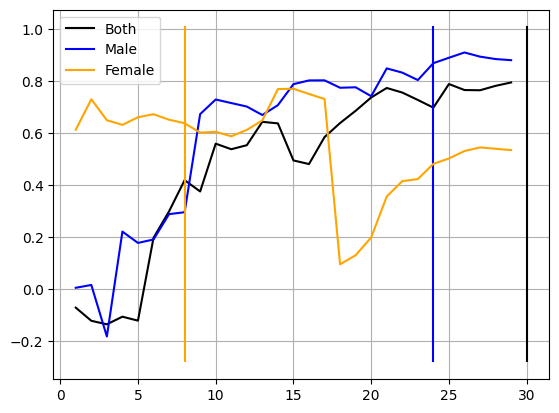

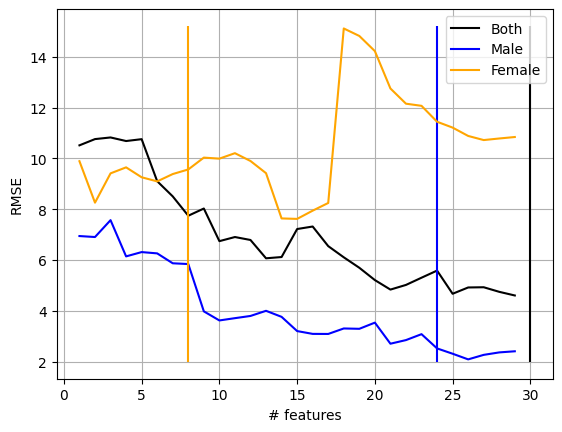

In [55]:
plt.figure()

ymax=np.max(list(scores['r2'].values())) + 0.1
ymin=np.min(list(scores['r2'].values())) - 0.1



for (key, value), col in zip(scores['r2'].items(), ['black', 'blue', 'orange']):
    plt.plot(range(1,30), value, label=key, color=col)
    plt.vlines(x=min(datasets[key].shape[0]-1, 30), ymin=ymin, ymax=ymax, color=col)
plt.legend()
plt.grid(which='both')
plt.show()

ymax=np.max(list(scores['RMSE'].values())) + 0.1
ymin=np.min(list(scores['RMSE'].values())) - 0.1

plt.figure()
for (key, value), col in zip(scores['RMSE'].items(), ['black', 'blue', 'orange']):
    plt.plot(range(1,30), value, label=key, color=col)
    plt.vlines(x=min(datasets[key].shape[0]-1, 30), ymin=ymin, ymax=ymax, color=col)
plt.xlabel("# features")
plt.ylabel("RMSE")
plt.legend()
plt.grid(which='both')
plt.show()


In [72]:
n_features = {
    'Both': 7,
    'Male': 10, #21
    'Female': 2
}


results = {}

for key, dataset in datasets.items(): 
    rmses = []
    r2_scores = []

    if min(adata_nona.shape[0], adata_male_nona.shape[0], adata_female_nona.shape[0]) < 10:
        cv  = LeaveOneOut()
    else:
        cv = StratifiedKFold(n_splits=5)
    
    transcripts = transcripts_dict[key]

    X = dataset[:, transcripts[:n_features[key]]].X
    y = dataset.obs['age'].values

    preds = np.zeros(len(y))
    vals  = np.zeros(len(y))

    for i, (train, val) in enumerate(cv.split(X, y)):
        X_train = X[train]
        y_train = y[train]
        X_test = X[val]
        y_test = y[val]
        
        train_scaler = RobustScaler().fit(X_train)
        X_train = train_scaler.transform(X_train)
        X_test = train_scaler.transform(X_test)
        
        X_train_ = X_train
        y_train_ = y_train
        X_val = X_test
        y_val = y_test
        
            
        
        # model = xgb.XGBRegressor(n_estimators=300, max_depth=4)
        model = svm.SVR(kernel='linear')
        # model = Ridge()
        
        
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        
        preds[val] = pred
        vals[val] = y_val
        
        # preds.extend(pred)
        # vals.extend(y_val)
        
    results[key] = {}
    results[key]['preds'] = preds
    results[key]['vals'] = vals

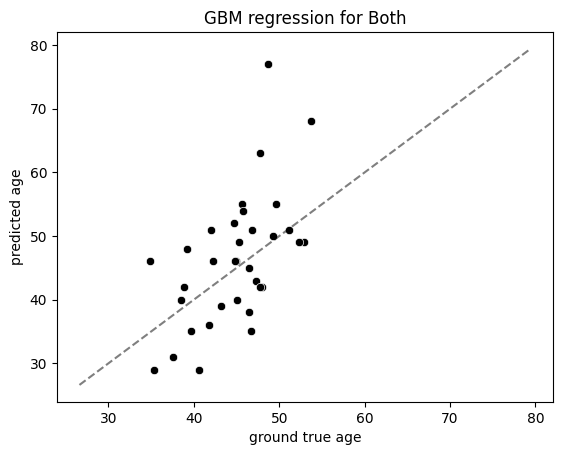

8.505160161637722


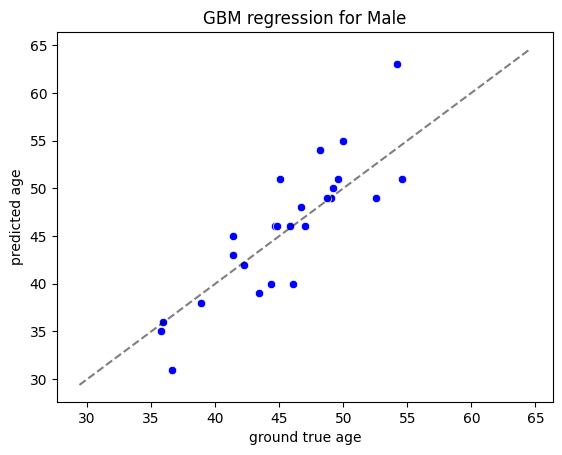

3.6281616519094215


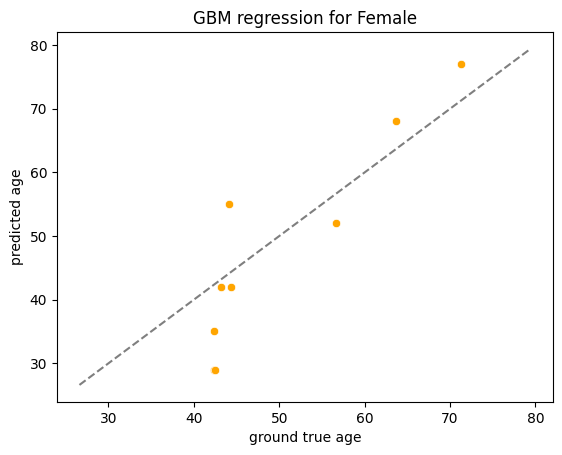

8.258667517468115


In [73]:
for (key, val), col in zip(results.items(), ['black', 'blue', 'orange']):

    g = sns.scatterplot(
        y=np.array(val['vals']).ravel(), 
        x=np.array(val['preds']).ravel(), 
        # hue=datasets[key].obs['chamber']
        color=col,

        )
    g.set_title(f"GBM regression for {key}")
    g.set_ylabel("predicted age")
    g.set_xlabel("ground true age")

    lims = [
        np.min([g.get_xlim(), g.get_ylim()]),  # min of both axes
        np.max([g.get_xlim(), g.get_ylim()]),  # max of both axes
    ]

    # sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    g.plot(lims, lims, '--', color='k', alpha=0.5)
    
    plt.show()
    
    print(RMSE(np.ravel(val['vals']), np.ravel(val['preds'])))


In [74]:
result = {}
for key, dataset in datasets.items(): 
    # print(transcripts[:n_features[key]].str[3:])
    result[key] = transcripts[:n_features[key]].str[3:].tolist()
result

{'Both': ['ENST00000710866.1',
  'ENST00000541782.1',
  'MSTRG.10181.25',
  'MSTRG.10181.35',
  'ENST00000339997.8',
  'MSTRG.23633.30',
  'ENST00000396651.8'],
 'Male': ['ENST00000710866.1',
  'ENST00000541782.1',
  'MSTRG.10181.25',
  'MSTRG.10181.35',
  'ENST00000339997.8',
  'MSTRG.23633.30',
  'ENST00000396651.8',
  'ENST00000636409.1',
  'ENST00000320640.11',
  'ENST00000683787.1'],
 'Female': ['ENST00000710866.1', 'ENST00000541782.1']}

['ENST00000710866.1', 'ENST00000541782.1', 'MSTRG.10181.25', 'MSTRG.10181.35', 'ENST00000339997.8', 'MSTRG.23633.30', 'ENST00000396651.8', 'ENST00000636409.1', 'ENST00000320640.11', 'ENST00000683787.1']
['ENST00000710866.1', 'ENST00000541782.1']
{'ENST00000541782.1', 'ENST00000710866.1'}


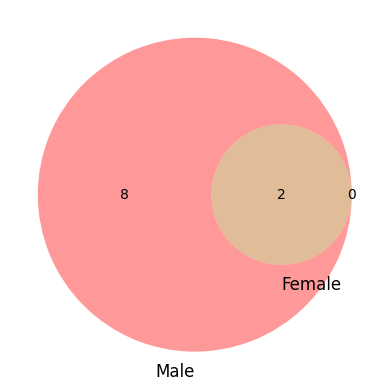

In [75]:
from matplotlib_venn import venn2

inters = set(result['Male']).intersection(set(result['Female']))
male = set(result['Male']).difference(set(result['Female']))
female = set(result['Female']).difference(set(result['Male']))

print(result['Male'])
print(result['Female'])
print(inters)

venn2(subsets = (len(male), len(female), len(inters)), set_labels = ('Male', 'Female'))
plt.show()